In [144]:
#adding more layers to the ANN 
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.inspection import permutation_importance

In [38]:
df = pd.read_csv('CellShapeR-tidy.csv')
df.head()

,group,circ,solidity
0,PRDWT,0.43928,0.90661
1,PRDWT,0.37629,0.89330
2,PRDWT,0.42030,0.89177
3,PRDWT,0.18643,0.77799
4,PRDWT,0.15806,0.68415


In [40]:
na_counts = df.isna().sum()
print(na_counts)

group       0
circ        0
solidity    0
dtype: int64


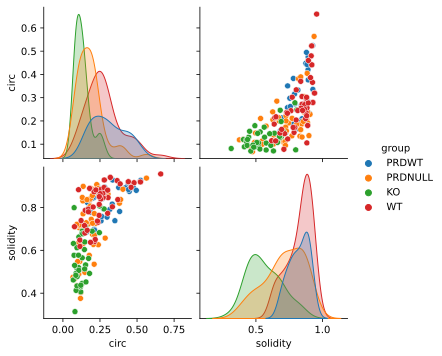

In [42]:
sns.pairplot(df, hue='group')
plt.show()

In [99]:
# convert from pandas dataframe to tensor
data = torch.tensor(df[df.columns[1:3]].values).float()

# transform categorical to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[df.group=='PRDWT'] = 0
labels[df.group=='PRDNULL'] = 1
labels[df.group=='KO'] = 2
labels[df.group=='WT'] = 3
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3])

In [209]:
# model architecture
ANNwave = nn.Sequential(
    nn.Linear(2,8),   # input layers circ solidity
    nn.ReLU(),         # activation
    nn.Linear(8,8),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(8,4),   # output layer group
      )

# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNwave.parameters(),lr=.25)

In [211]:
numepochs = 2000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochs in range(numepochs):

  # forward pass
  yHat = ANNwave(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochs] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy
  matches = torch.argmax(yHat,axis=1) == labels # booleans (false/true)
  matchesNumeric = matches.float()              # convert to numbers (0/1)
  accuracyPct = 100*torch.mean(matchesNumeric)  # average and x100
  ongoingAcc.append( accuracyPct )              # add to list of accuracies
    
# final forward pass
predictions = ANNwave(data)

predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == labels).float())

In [213]:
torch.argmax(yHat,axis=1);

Final accuracy: 49.7175%


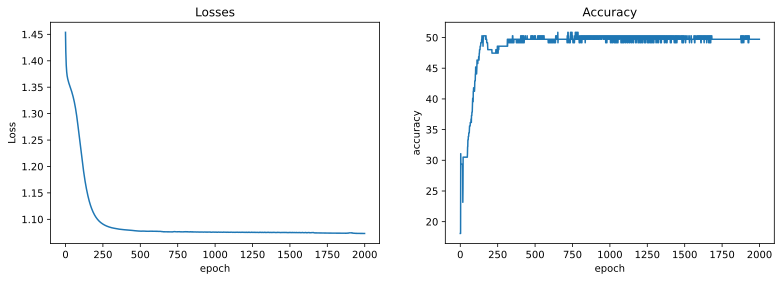

In [215]:
# accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()